## Introduction

Washington State University's Decision Aid System as well as others have provided tree fruit growers with population phenology models for the common pest known as codling moth (_Cydia pomonella_) for years which have been shown to be quite reliable, and much research has been done into the population dynamics of codling moth subject to the manipulation various independent variables. One inconsistency relayed to the WSU CAHNRS Dept. of Entomology by growers is a discrepancy in the time our models expect the first emergences of the overwintering generation, and when their traps actually find evidence of them. Some organizations have asserted that these first trap captures are indicitive of the _real_ first emergence times, stating that they should be used as a sort of "biofix" that the models must be translated over to match. The fact that the same growers report significantly better matching in the second and third generations suggests to us that this is not the case, and we hypothesize that it is the result of sampling error that causes the difference in time between first emergence and first capture in these systems. Due to the very monolithic management of real orchards making field data not useful, and the very long turnaround times for new lab data to become available, it has been opted to use a simulation generating data matching key expectations gathered in previous lab studies to investigate the problem. The simulation is used to generate a swathe of data as a convolution of three varying degrees of freedom in the starting conditions (starting population size of the overwintering generation, percentage chance to capture a moth on a given degree day, and the average mating delay experienced by the moths).

## Import libraries and split into individual dataframes for each permutation of variables

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
df = pd.read_csv('test_1.csv')
dfs = np.array_split(df, len(df)/df.dd_span.head(1).iloc[0])

In [2]:
dfs[0].head()

,dd,captured,pop_active_0,pop_active_1,pop_active_2,pop_emerged_0,pop_emerged_1,pop_emerged_2,eggs_0,eggs_1,eggs_2,eggs_total_0,eggs_total_1,eggs_total_2,Unnamed: 14,pop_0,prob_capture,mating_delay,dd_span
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,1000,0.0,0.0,NaN,1000,0.01,0,2201
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,1000,0.0,0.0,NaN,1000,0.01,0,2201
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,1000,0.0,0.0,NaN,1000,0.01,0,2201
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,1000,0.0,0.0,NaN,1000,0.01,0,2201
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1000.0,0.0,0.0,1000,0.0,0.0,NaN,1000,0.01,0,2201


## Compile data about capture-emergence difference and clean instances with no first generation captures and/or first generation emergences

In [3]:
def compile_diffs(dfs, thresh: int):
    capture_data = []
    for frame in dfs:
        first_capture = frame[frame.captured > thresh].head(1).dd
        first_emergence = frame[(frame.pop_emerged_0 > thresh)].head(1).dd
        if not first_capture.empty and not first_emergence.empty:
            diff = first_capture.iloc[0] - first_emergence.iloc[0]
            pop_0 = frame.head(1).pop_0.iloc[0]
            prob_capture = frame.head(1).prob_capture.iloc[0]
            mating_delay = frame.head(1).mating_delay.iloc[0]
            ratio_naive = pop_0 * prob_capture
            ratio = (pop_0 ** 1/3) * (prob_capture ** 3)
            capture_data.append((diff, ratio, ratio_naive, pop_0, prob_capture, mating_delay))
    return capture_data

first_capture_data = compile_diffs(dfs, 1)

Two ratios are generated here for combinations between overwintering pop size and capture probability, a naive ratio just by multiplying them together (yes, I know this technically isn't a ratio since it's not divison, but since one of these values is very big and the other very small, multiplying gives much nicer numbers and is no less valid as a combination of the two than if I chose to multiply), and a better ratio by multiplying the cube root of the population to the cube of the capture probability. This balances out their relative importance in determining the difference much better, as will be demonstrated.

## Organize data into three dataframes, a unified frame, an explanitory varaible frame, and a dependent variable frame

In [4]:
capture_df = pd.DataFrame(first_capture_data, columns=['difference', 'ratio', 'naive_ratio', 'pop_0', 'prob_capture', 'mating_delay'])
df_x = capture_df.drop('difference', axis=1)
df_y = capture_df['difference']

## View variables against each other

<Axes: xlabel='mating_delay', ylabel='difference'>

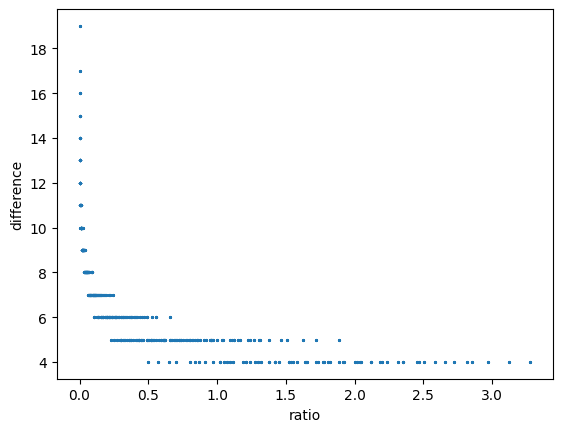

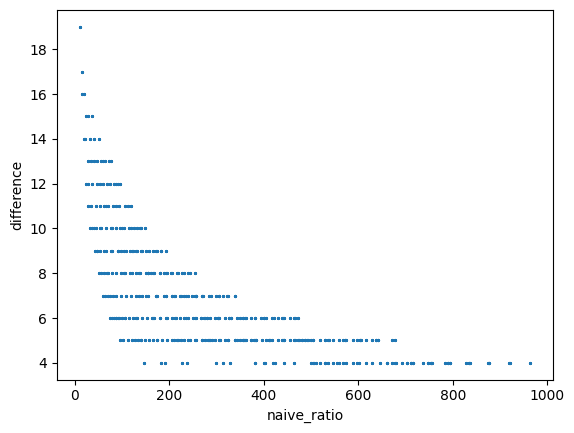

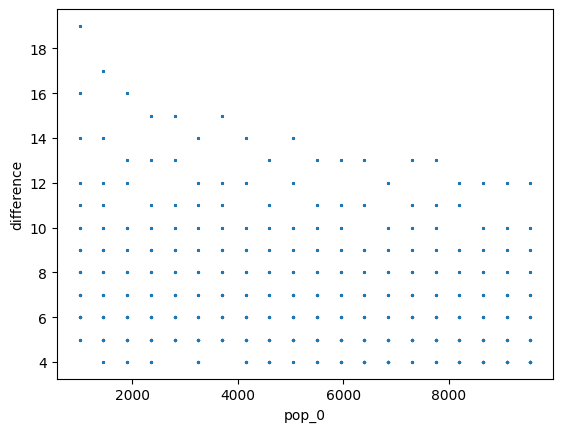

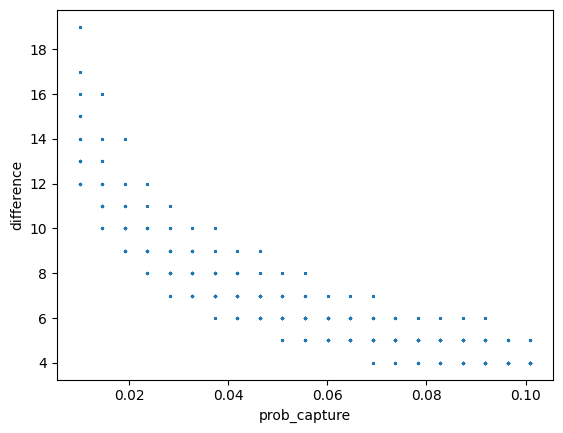

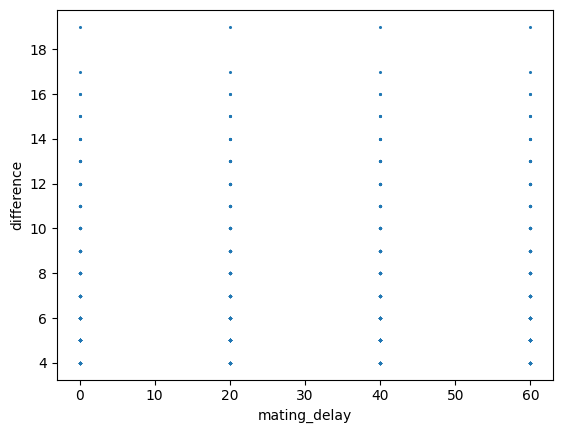

In [5]:
is_log = False
capture_df.plot.scatter(1, 0, 1.5, loglog=is_log)
capture_df.plot.scatter(2, 0, 1.5, loglog=is_log)
capture_df.plot.scatter(3, 0, 1.5, loglog=is_log)
capture_df.plot.scatter(4, 0, 1.5, loglog=is_log)
capture_df.plot.scatter(5, 0, 1.5, loglog=is_log)

## Create function for automatically fitting reciprocal functions using inverse-composition linearization

In [6]:
def autofit_reciprocal(x, y, a_guess, b_guess, c_guess, full_output=False):
    a = a_guess
    b = b_guess
    c = c_guess
    slope = 2
    intercept = 1

    # fit 'b' parameter
    magnitude = 1
    for _ in range(1,50):
        y_linear = np.power(np.multiply(np.reciprocal(np.subtract(y, b)), a), 1 / c)
        p = np.polyfit(x, y_linear, 1, w=np.log(y))
        b_below = b + (0.1 ** magnitude)
        b_above = b - (0.1 ** magnitude)
        y_linear_above = np.power(np.multiply(np.reciprocal(np.subtract(y, b_above)), a), 1 / c)
        y_linear_below = np.power(np.multiply(np.reciprocal(np.subtract(y, b_below)), a), 1 / c)
        p_above = np.polyfit(x, y_linear_above, 1, w=np.log(y))
        p_below = np.polyfit(x, y_linear_below, 1, w=np.log(y))
        if abs(p[1]) < abs(p_above[1]) and abs(p[1]) < abs(p_below[1]):
            magnitude = magnitude + 1
        elif abs(p_above[1]) < abs(p_below[1]):
            b = b_above
        elif abs(p_below[1]) < abs(p_above[1]):
            b = b_below

    # fit 'a' parameter
    magnitude = 0
    for _ in range(1,50):
        y_linear = np.power(np.multiply(np.reciprocal(np.subtract(y, b)), a), 1 / c)
        p = np.polyfit(x, y_linear, 1, w=np.log(y))
        a_below = a + (0.1 ** magnitude)
        a_above = a - (0.1 ** magnitude)
        y_linear_above = np.power(np.multiply(np.reciprocal(np.subtract(y, b)), a_above), 1 / c)
        y_linear_below = np.power(np.multiply(np.reciprocal(np.subtract(y, b)), a_below), 1 / c)
        p_above = np.polyfit(x, y_linear_above, 1, w=np.log(y))
        p_below = np.polyfit(x, y_linear_below, 1, w=np.log(y))
        # print(f'{a}, {p_above[0]}, {p[0]}, {p_below[0]}')
        if abs(p[0] - 1) < abs(p_above[0] - 1) and abs(p[0] - 1) < abs(p_below[0] - 1):
            magnitude = magnitude + 1
        elif abs(p_above[0] - 1) < abs(p_below[0] - 1):
            a = a_above
        elif abs(p_below[0] - 1) < abs(p_above[0] - 1):
            a = a_below
    if full_output:
        return (a, b, p)
    else:
        return (a, b)

## Fit curve to data using naive ratio

0.999996876200253 -3.005990248565872e-13


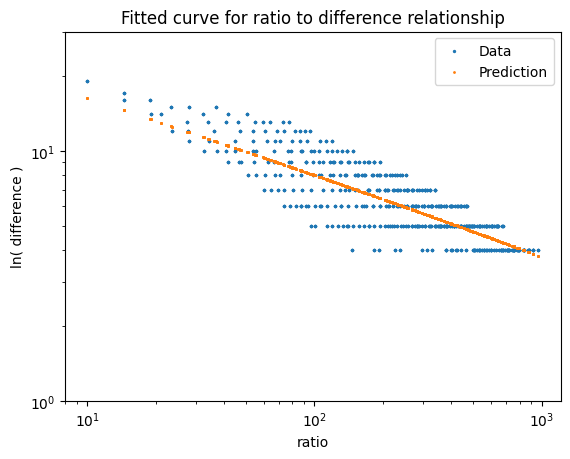

In [7]:
x = capture_df.naive_ratio
y = capture_df.difference

c = 0.29
a, b, p = autofit_reciprocal(x, y, 3, 0.3, c, full_output=True)
print(*p)

y_linear_naive = np.power(np.multiply(np.reciprocal(np.subtract(y, b)), a), 1 / c)

fitted_x = np.linspace(x.min(), x.max(),1000)
fitted_y_naive = np.add(np.multiply(np.reciprocal(np.power(x, c)), a), b)

ax = plt.axes()
ax.scatter(x, y, label='Data', s=2)
ax.scatter(x, fitted_y_naive, label='Prediction', s=1)
ax.set_title('Fitted curve for ratio to difference relationship')
ax.set_ylabel('ln( difference )')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1, 30)
ax.set_xlabel('ratio')
ax.legend()

## Check residuals

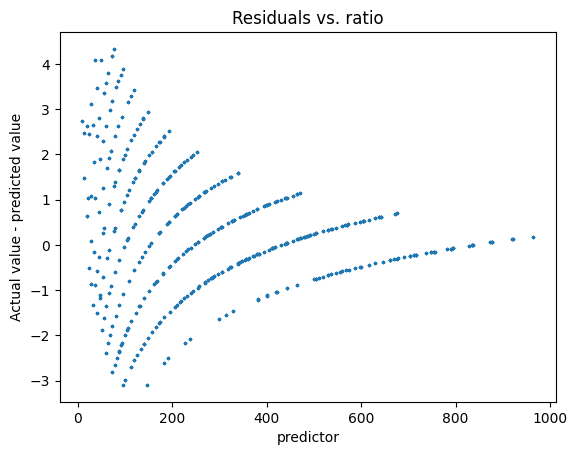

In [8]:
from scipy.stats import zscore

def residual_plot(x, y, fitted_y, log=False):
    data = {'ratio': x, 'residual':np.subtract(y, fitted_y)}
    residuals = pd.DataFrame(data)
    #residuals = residuals[(np.abs(zscore(residuals.residual)) < 4)]
    ax = plt.axes()
    ax.scatter(residuals.ratio, residuals.residual, label='Data', s=2)
    ax.set_title('Residuals vs. ratio')
    ax.set_ylabel('Actual value - predicted value')
    ax.set_xlabel('predictor')
    if log:    
        ax.set_yscale('log')
        ax.set_xscale('log')

residual_plot(x, y, fitted_y_naive)

heteroscedasticity could definitely be improved

## Fit curve to data using smarter ratio

(3.660890776116469, 0.8979282714661776)


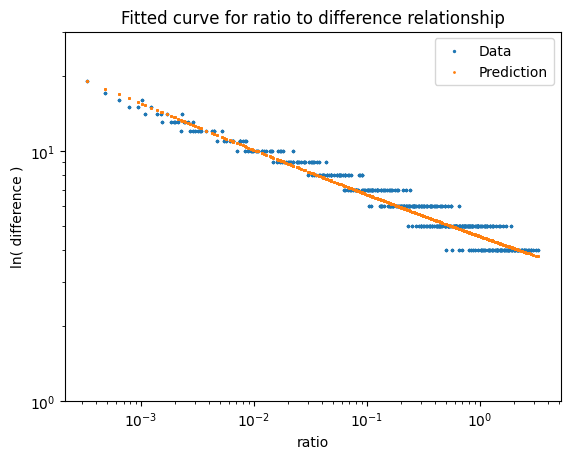

In [9]:
x = capture_df.ratio
y = capture_df.difference

c = 0.2
a, b = autofit_reciprocal(x, y, 3, 0.7, c)

y_linear = np.power(np.multiply(np.reciprocal(np.subtract(y, b)), a), 1 / c)

fitted_x = np.linspace(x.min(), x.max(),1000)
fitted_y = np.add(np.multiply(np.reciprocal(np.power(x, c)), a), b)

ax = plt.axes()
ax.scatter(x, y, label='Data', s=2)
ax.scatter(x, fitted_y, label='Prediction', s=1)
ax.set_title('Fitted curve for ratio to difference relationship')
ax.set_ylabel('ln( difference )')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1, 30)
ax.set_xlabel('ratio')
ax.legend()
print((a, b))

For the ratio function of (pop_0^1/3) * (prob_capture^3), a function of y = (3.024 / x ^ 0.2) + 0.965 predicts the difference in first emergence and first capture.

## Determine goodness of fit by looking at residuals

### Residual Plot

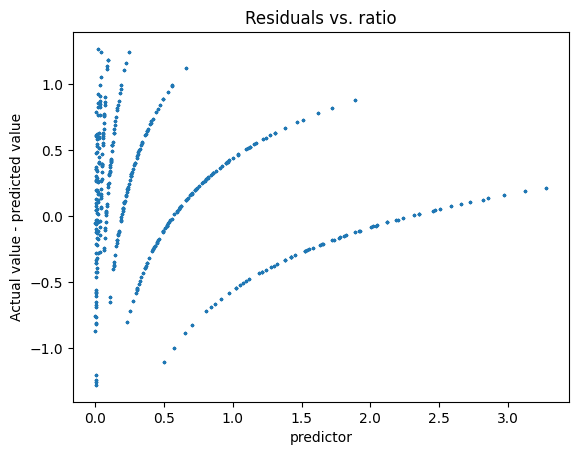

In [10]:
residual_plot(x, y, fitted_y)

Definitely still some heteroscedasticity, but it looks like the worst of it is only +/- 1. Measureable improvement from the naive ratio. Furthermore, from looking at the fitted curve graphs of the two, no value of 'c' was able to match both the extreme and median points to a satisfactory degree with the naive ratio, but a 'c' of 0.2 matches both quite well with the smarter combination

### Average bias per point

In [11]:
np.sum(np.subtract(y, fitted_y)) / len(x)

0.14099709146460362

The fitted curve is a little biased relative to the actual data, but I again feel that less than a fifth of a degree day average negative bias is satisfactory for practical use.

## At this point I decide to rethink which parameter I want to base the model off of

My rationale is this: One of the biggest issues I'm facing in making this model is the extreme instability around small ratio values, and if you look at the difference vs predictor graphs I have towards the top, you can visually see that it is mostly the fault of the "size of the overwintering population" (pop_0) to blame for this. Furthermore, this parameter would be _very_ difficult to get an actual read on in the field. Furthermore, if I do analysis on the sampling effort with a constant population, then that allows me to trivially apply these differences to the known phenology curves, which are in proportions of total population and not integer moth counts. If the population is kept constant through the first generation, just multiply the phenology curves by that constant number to apply the differences, and then divide again to get back to proportions. The capture probability parameter is both more uniformly stable around small values, and also is actually feasible to estimate in real world situations, so I'm going to generate a new data set, holding both mating delay and pop_0 constant, so as to get a direct look at the effect of the per degree day capture probability with significantly higher resolution. I also had to modify the data output from the simulation to get an integrated energence value, as the current system for using the population active works explicitly only for the first emergence, as any past that are subject to death and capture diminishing the true number of emergences.

## Build DataFrames for the new focused set

In [12]:
df = pd.read_csv('test_2.csv')
dfs = np.array_split(df, len(df)/df.dd_span.head(1).iloc[0])

## Investigate also how the difference evolves when looking at second captures, third captures, etc.

### Compile 1st through 90th differences

In [13]:
diffs = []
for i in range(1,91):
    row = compile_diffs(dfs, i)
    row_df = pd.DataFrame(row, columns=['difference', 'ratio', 'naive_ratio', 'pop_0', 'prob_capture', 'mating_delay'])
    diffs.append(row_df)

len(diffs)

90

### Look at the graphs of the first, second, third, fifth, tenth, and fiftheenth differences against the probability of capture

<Axes: title={'center': 'Fifteenth diffs'}, xlabel='prob_capture', ylabel='difference'>

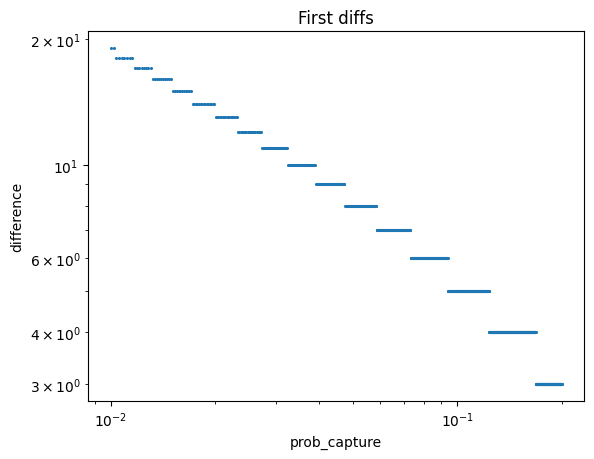

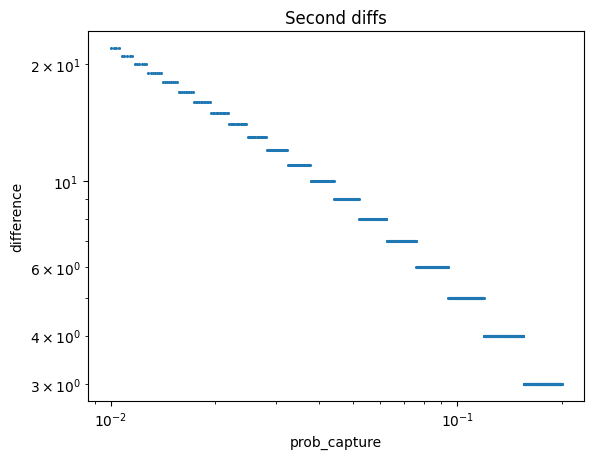

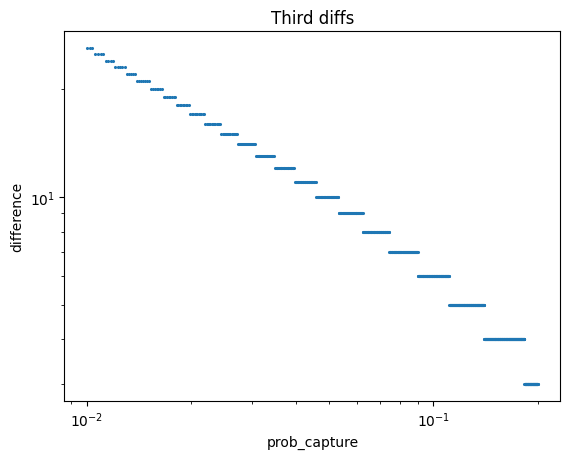

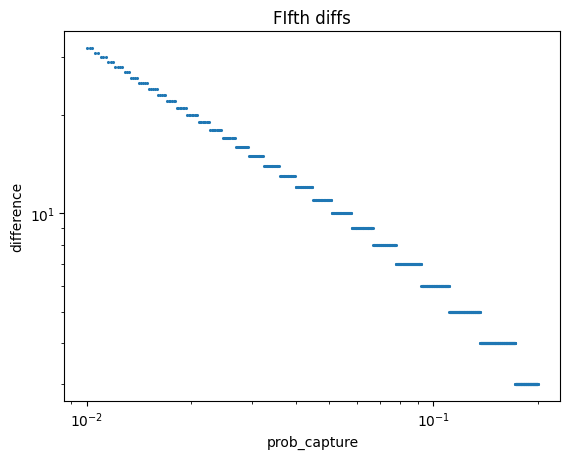

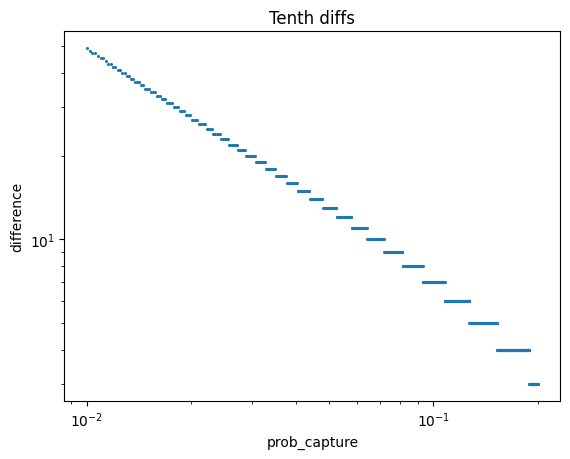

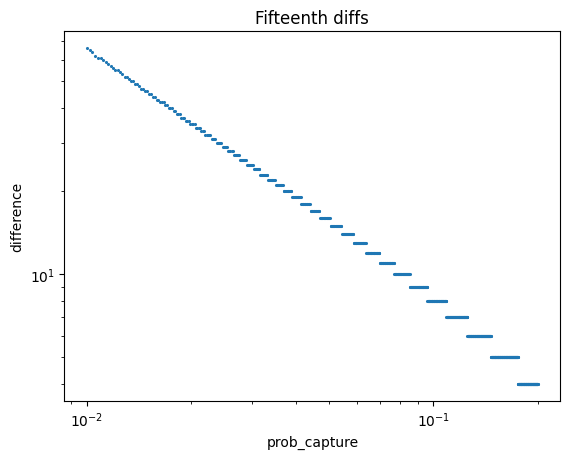

In [14]:
is_log = True
diffs[0].plot.scatter(4, 0, 1.5, title='First diffs', loglog=is_log)
diffs[1].plot.scatter(4, 0, 1.5, title='Second diffs', loglog=is_log)
diffs[2].plot.scatter(4, 0, 1.5, title='Third diffs', loglog=is_log)
diffs[4].plot.scatter(4, 0, 1.5, title='FIfth diffs', loglog=is_log)
diffs[9].plot.scatter(4, 0, 1.5, title='Tenth diffs', loglog=is_log)
diffs[14].plot.scatter(4, 0, 1.5, title='Fifteenth diffs', loglog=is_log)

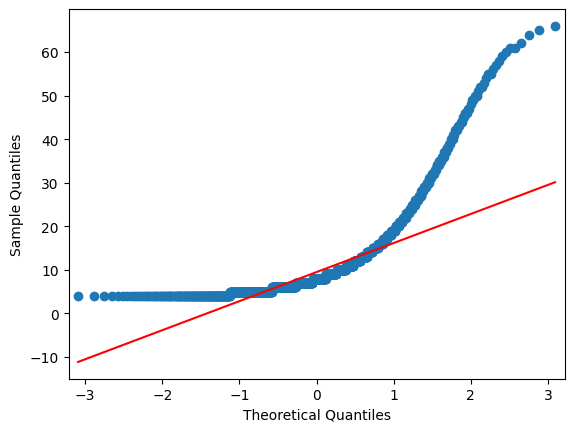

In [15]:
from statsmodels.api import qqplot
_ = qqplot(diffs[14].difference, line='q')

## Make a better fitting function for the more well behaved data

In [16]:
import statsmodels.formula.api as smf

def new_autofit(x, y, residuals=False, full_output=False):
    data = pd.DataFrame({'difference':y, 'prob_capture':x})
    model = smf.ols('np.log(difference) ~ np.log(prob_capture)', data=data).fit()
    if full_output:
        print(model.summary())
    if residuals:
        return (model.params[1], np.exp(model.params[0]), model.resid)
    return (model.params[1], np.exp(model.params[0]))


                            OLS Regression Results                            
Dep. Variable:     np.log(difference)   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 3.880e+05
Date:                Thu, 19 Oct 2023   Prob (F-statistic):               0.00
Time:                        21:29:06   Log-Likelihood:                 1716.2
No. Observations:                1001   AIC:                            -3428.
Df Residuals:                     999   BIC:                            -3419.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -0.1629 

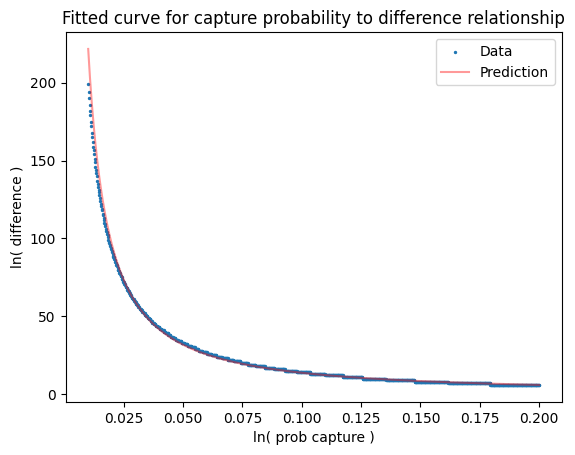

In [17]:
n = 50
x = diffs[n].prob_capture
y = diffs[n].difference

a, b, resid = new_autofit(x, y, residuals=True, full_output=True)

fitted_x = np.linspace(x.min(), x.max(), len(y))
fitted_y = np.multiply(np.power(x,a), b)

ax = plt.axes()
ax.scatter(x, y, label='Data', s=2)
ax.plot(x, fitted_y, label='Prediction', alpha=0.4, color='red')
ax.set_title('Fitted curve for capture probability to difference relationship')
ax.set_ylabel('ln( difference )')
#ax.set_yscale('log')
#ax.set_xscale('log')
ax.set_xlabel('ln( prob capture )')
ax.legend()

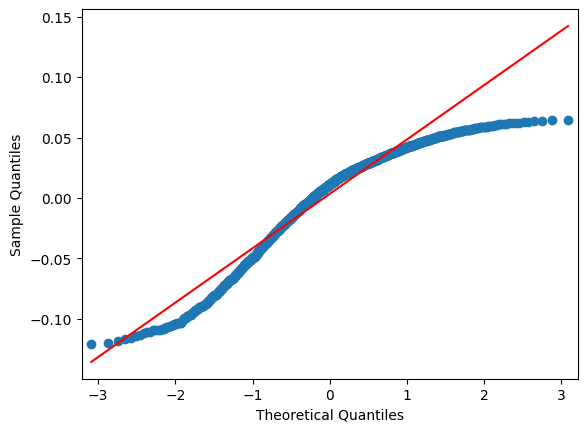

In [18]:
_ = qqplot(resid, line='q')

These residuals aren't perfect but I believe they are well within the realm of acceptability

### Model the change in models!

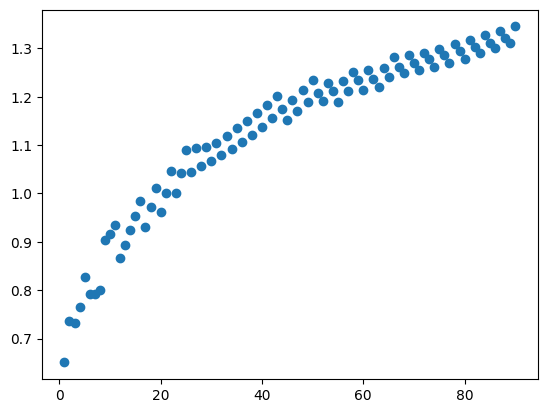

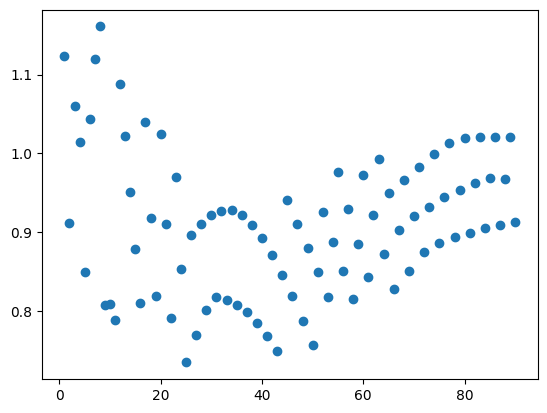

In [19]:
model_mat = []
for diff in diffs:
    a, b = new_autofit(diff.prob_capture, diff.difference)
    model_mat.append((a,b))
    
a = np.array(model_mat).T[0]
a = -a
b = np.array(model_mat).T[1]
x = np.arange(1,len(diffs)+1)



plt.scatter(x, a)
#plt.xscale('log')
#plt.yscale('log')
plt.show()
plt.scatter(x, b)
#plt.xscale('log')
#plt.yscale('log')
plt.show()

                            OLS Regression Results                            
Dep. Variable:           np.log(coef)   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     3297.
Date:                Thu, 19 Oct 2023   Prob (F-statistic):           1.55e-71
Time:                        21:29:07   Log-Likelihood:                 199.92
No. Observations:                  90   AIC:                            -395.8
Df Residuals:                      88   BIC:                            -390.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.5090      0.011    -45.

(0.17502777489213378, 0.6011037790193213)

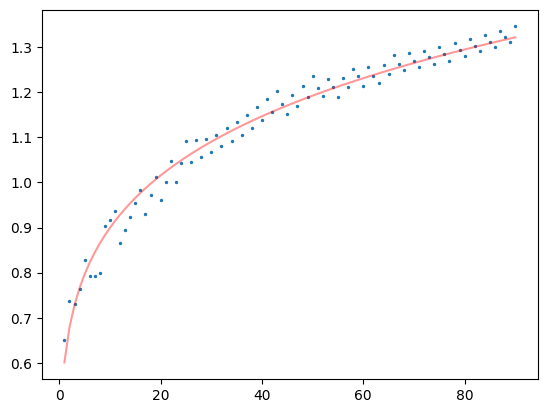

In [20]:
data = pd.DataFrame({'coef':a, 'n_diff':x})
model = smf.ols('np.log(coef) ~ np.log(n_diff)', data=data).fit()
a_a = model.params[1]
a_b = np.exp(model.params[0])
y_fitted = np.multiply(np.power(x,a_a), a_b)
print(model.summary())
ax = plt.axes()
ax.scatter(x, a, label='Data', s=2)
ax.plot(x, y_fitted, label='Prediction', alpha=0.4, color='red')
(a_a, a_b)

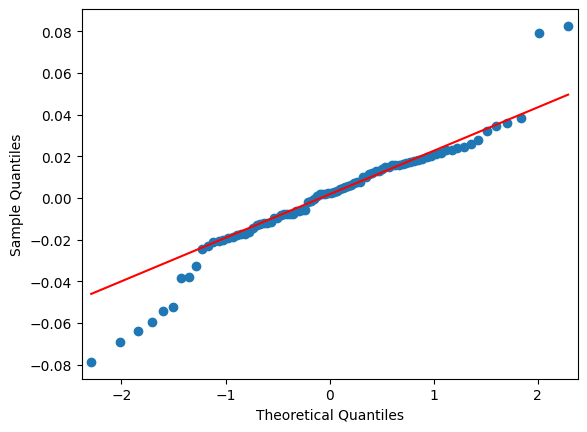

In [21]:
_ = qqplot(model.resid, line='q')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.312
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     13.01
Date:                Thu, 19 Oct 2023   Prob (F-statistic):           4.37e-07
Time:                        21:29:07   Log-Likelihood:                 105.88
No. Observations:                  90   AIC:                            -203.8
Df Residuals:                      86   BIC:                            -193.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0631      0.034     31.667      0.0

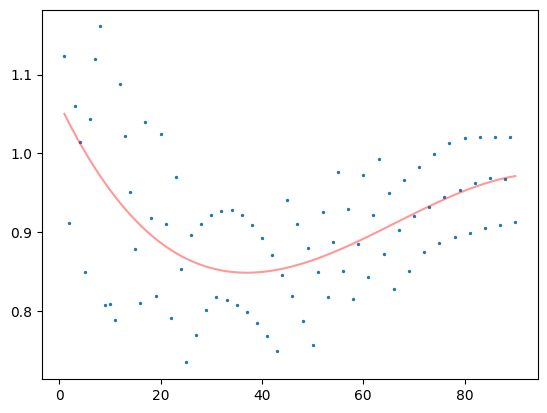

In [22]:
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
polynomial_features= PolynomialFeatures(degree=3)
x_reshape = x.reshape(-1, 1)
xp = polynomial_features.fit_transform(x_reshape)
model = sm.OLS(b, xp).fit()
print(model.summary())
y_fitted = model.predict(xp)
ax = plt.axes()
ax.scatter(x, b, label='Data', s=2)
ax.plot(x, y_fitted, label='Prediction', alpha=0.4, color='red')

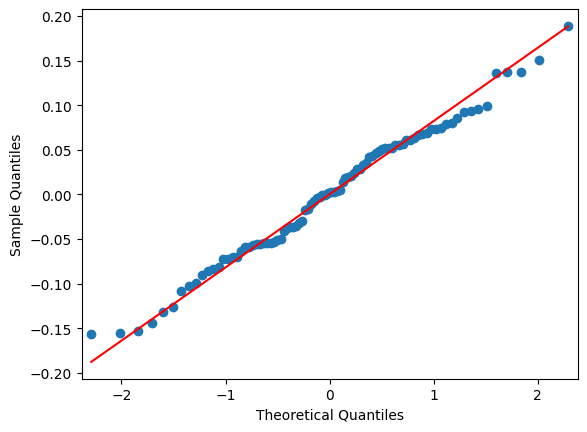

In [23]:
_ = qqplot(model.resid, line='q')

The model for the exponent of the power law is REALLY good, the residuals show that the true distribution may have *ever so slightly* heavier tails than the fitted model, but with such low variance thats something that is totally fine by me.  
The model for the coefficient isn't as spot on, but the almost perfectly normally distributed residuals lead me to believe that it isn't going to get much better than that. I'm honestly okay with that, because the exponent is SIGNIFICANTLY more important for prediction than having a 10% noise term on the coefficient.

Pulling the analysis together, the simulated data predicts that, assuming there is a starting overwintering population size of 1,000, the equation that relates difference and sampling effort is the following:
$$ f(x,n) = \hat{y} = ax^b + \epsilon $$
where:
$$\begin{flalign}a &= (-1.256*10^{-6})n^3 + 0.0002n^2 - 0.0133n + 1.0631 \\
b &= (0.601)n^{0.175} \\
x &= \textrm{ percentage change to capture one moth over one degree day (sampling effort) } \\
\hat{y} &= \textrm{ difference in degree days between the emergence of the n-th moth and capture of n moths} \\
\epsilon &= \textrm{ model error and noise } \end{flalign}$$

Because the population was kept constant (1,000) for the simulation data set involved in this section of the analysis, the method of application to the phenology curves just involves multiplying the phenology curve by 1,000, choosing points in the curve where $y = n$, and adding the value of $f(x,n)$ to the degree day value for the phenology curve where $y=n$. The idea is to do this for a range of $n$, then use the resulting shifted points to fit a new, flatter Johnson SB distribution, which is the predicted field curve under a given sampling effort. Even though the concrete unit for sampling effort for this equation is 'percentage change to capture a moth in a single degree day under the conditions of the simulation', other units of sampling effort (such as trap number or trap density) could be investigated for conversion factors to this rather arbitrary unit by analysis of field data.

## Analysis of Field Data

In [24]:
oksir = pd.read_csv('region_A1a.csv')
oksir.head()

,Unnamed: 0,X,Y,Date,julian,Wild,Year
0,1,-119.580568,49.126713,2015-04-13,103,0.0,2015
1,2,-119.581150,49.127490,2015-04-13,103,0.0,2015
2,3,-119.581465,49.128551,2015-04-13,103,0.0,2015
3,4,-119.578896,49.128906,2015-04-13,103,0.0,2015
4,5,-119.579639,49.131926,2015-04-13,103,0.0,2015


In [28]:
years = oksir.Year.unique()
oksir_year = {}
for year in years:
    oksir_year[year] = oksir[oksir['Year'] == year]
oksir_year[2015].head()

,Unnamed: 0,X,Y,Date,julian,Wild,Year
0,1,-119.580568,49.126713,2015-04-13,103,0.0,2015
1,2,-119.581150,49.127490,2015-04-13,103,0.0,2015
2,3,-119.581465,49.128551,2015-04-13,103,0.0,2015
3,4,-119.578896,49.128906,2015-04-13,103,0.0,2015
4,5,-119.579639,49.131926,2015-04-13,103,0.0,2015


In [59]:
from scipy.stats import johnsonsb

def num_traps(data):
    return len(data.X.unique())
def jw_emergence(dd):
    gamma = 1.0737
    delta = 1.2349
    llambda = 577.2
    zeta = 69.0
    return 1000 * johnsonsb.cdf(dd, gamma, delta, loc=zeta, scale=llambda)
def 

In [64]:
oksir_year[2015][oksir_year[2015]['Wild'] > 0.9]

,Unnamed: 0,X,Y,Date,julian,Wild,Year
2171,2172,-119.486687,49.038550,2015-04-29,119,1.0,2015
2354,2355,-119.586762,49.157593,2015-04-30,120,1.0,2015
3532,3533,-119.506544,49.058461,2015-05-01,121,1.0,2015
3562,3563,-119.558380,49.172682,2015-05-01,121,1.0,2015
3565,3566,-119.556802,49.174596,2015-05-01,121,4.0,2015
6914,6915,-119.561292,49.159524,2015-05-07,127,4.0,2015
10152,10153,-119.465308,49.002689,2015-05-11,131,1.0,2015
10556,10557,-119.508043,49.059137,2015-05-12,132,1.0,2015
10581,10582,-119.567339,49.159084,2015-05-12,132,1.0,2015
10582,10583,-119.561292,49.159524,2015-05-12,132,2.0,2015


In [65]:
years

array([2015, 2014, 2004, 1998, 2009, 2001, 2007, 2013, 2000, 2002, 1995,
       1996, 1999, 2006, 2008, 2010, 2005, 1997, 2012, 2011])

In [80]:
year_jul = []
for year in years:
    year_jul.append((year, oksir_year[year].head(1).julian.item(), oksir_year[year][oksir_year[year]['Wild'] > 0.9].head(1).julian.item()))
year_jul
years_table = pd.DataFrame(columns=['year','first_julian','first_emergence_julian'], data=year_jul)
years_table.head()

,year,first_julian,first_emergence_julian
0,2015,103,119
1,2014,105,126
2,2004,109,116
3,1998,110,117
4,2009,110,132
